# Data analysis for the chapter "Full RE states"

This notebook can be used to reproduce the data analysis of the Chapter "Full RE states" of the technical report ["Assessing a Formal Model of Reflective Equilibrium"](https://re-models.github.io/re-technical-report/). 

## How to run this notebook

There are several possibilities to execute this notebook. You can, for instance,

1. execute this notebook on Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/re-models/re-technical-report/blob/main/notebooks/data_analysis_chapter_full_re_states.ipynb), or
2. execute this notebook locally in, for instance, [JupyterLab](https://jupyter.org/) by cloning the Github repository of the report (for details, see <https://github.com/re-models/re-technical-report>).

Note, however, that Colab is not suited to analyse the full data set that is used in the report. Instead, you can only use the subdata set `TINY` (see <https://github.com/re-models/re-technical-report> for details).

## Installing and importing libraries

In [1]:
!pip install re-technical-report

In [2]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import DataFrame
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from re_technical_report import (
    re_data_by_name,
    rel_share_of_property,
    plot_multiple_error_bars,
    heat_maps_by_weights,
    set_errorbar_plot_style,
    set_heatmap_plot_style,
)

## Loading Data

In [3]:
# Directories that are use to save generated tables and figures.
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

# Are we on Colab?
on_colab = 'google.colab' in str(get_ipython())

# Configuring sns styles
set_errorbar_plot_style()
set_heatmap_plot_style()

In [4]:
# Columns relevant for this notebook.
usecols = ["model_name",
           "n_sentence_pool",
           "ds",
           "init_coms",
           "weight_account", 
           "weight_systematicity",
           "fixed_point_coms_consistent",
           "n_fixed_points",
           "n_global_optima",
           "fp_full_re_state",
           "go_full_re_state",
           "n_full_re_states",
           "fixed_point_is_full_re_state",
           "error_code"
          ]

In [5]:
# Columns that need to be evaluated literally 
evalcols =["fp_full_re_state",
           "go_full_re_state"]

In [6]:
# data_name: one of 'TINY', 'MINI', 'FULL'
re_data = re_data_by_name(data_name="TINY", 
                          usecols = usecols,
                          evalcols = evalcols,
                          filter_erroneous_runs = True)

C:\Users\afrei\Desktop\GitHub 2\re-technical-report\data


In [7]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 4136547
   Number of dialectical structures: 200
   Overall number of initial commitments: 80
   Sentence-pools: [6 7 8 9]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [8]:
# counting simulation setups
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                                                 "ds",
                                                 "n_sentence_pool",
                                                 "weight_account", 
                                                 "weight_systematicity", 
                                                 "init_coms"
                                                ])

re_data_unique_setups.groupby(['model_name']).size()

model_name
LinearGlobalRE       143973
LinearLocalRE        142219
QuadraticGlobalRE    143964
QuadraticLocalRE     143079
dtype: int64

## Setup Dataframes

If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point if they are reached on different paths from a simulation setup. The corresponing results are presented under rubric of *process perspective* in the technical report. Otherwise, the subsequent analysis comprises only unique fixed points per simulation setup resulting in what is called *result perspectve* in the technical report.

In [20]:
analyse_branches = False

`bootstrap` determines whether bootstrapping is applied to estimate the mean and the standard deviation. `n_resamples` sets the number of resamples use for bootstrapping.

In [21]:
bootstrap = True
n_resamples = 400

### Dataframe for global optima

In [22]:
# the analysis of global optima is not affected by status of `analyse_branches`

# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 'n_sentence_pool',
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity",
                                 #'n_global_optima',
                                 'go_full_re_state',
                                 #'n_full_re_states'
                                ]]

# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_full_re_state`)
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      'n_sentence_pool',
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity",
                                     ]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(2845799, 7)

In [23]:
# We restrict some graphics to two models variants for global optima 
# graphics in order to avoid (almost) redundant results.

go_models = ["LinearGlobalRE", "QuadraticGlobalRE"]

### Dataframe for fixed points

In [24]:
if analyse_branches:
    
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       'n_sentence_pool',
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       'fixed_point_is_full_re_state']]
    
    # rename fixed point columns 
    # note: df is already exploded
    exploded_fp_data = fp_data.rename(columns={'fixed_point_is_full_re_state': "fp_full_re_state",})
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     'n_sentence_pool',
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity", 
                                     "fp_full_re_state",
                                     #"n_fixed_points"
                                    ]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `fp_full_re_state`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          'n_sentence_pool',
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(1587288, 7)

## Results

### Tables

In [25]:
# separate tables for go and fp

for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = rel_share_of_property(df, 
                           "{}_full_re_state".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols=['model_name'],
                            collapse_branches=False,
                            cols_group_branches = ['model_name',
                                                   'ds',
                                                   'init_coms', 
                                                   'weight_account', 
                                                   'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    result_df.reset_index(inplace=True)
    
    # for later use
    if endpoint_type == "go":
        go_result_df = result_df
    else:
        fp_result_df = result_df
    
    # sort by model name
    result_df['model_name'] = pd.Categorical(result_df['model_name'], ["QuadraticGlobalRE", 
                                                                       "LinearGlobalRE", 
                                                                       "QuadraticLocalRE", 
                                                                       "LinearLocalRE"])
    result_df.sort_values("model_name", inplace=True)
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   'sum_go_full_re_state': 'Number of full RE global optima',
                   'size_go_full_re_state': 'Number of global optima',
                   'rel_go_full_re_state': 'Relative share of full RE global optima',
                   'std_go_full_re_state': 'Standard deviation', 
                   'sum_fp_full_re_state': 'Number of full RE fixed points',
                   'size_fp_full_re_state': 'Number of fixed points',
                   'rel_fp_full_re_state': 'Relative share of full RE fixed points',
                   'std_fp_full_re_state': 'Standard deviation',  
                  }

    display(result_df.rename(columns=cols_for_tables))
    
    
    if not on_colab:
        file_name = 'table_full_re_{}_{}.csv'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        result_df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)

,Model,Relative share of full RE global optima,Standard deviation,Number of full RE global optima,Number of global optima
2,QuadraticGlobalRE,0.115197,0.000380,82318,714584
0,LinearGlobalRE,0.274773,0.000524,192559,700830
3,QuadraticLocalRE,0.115262,0.000369,81750,709289
1,LinearLocalRE,0.254990,0.000487,183875,721096


,Model,Relative share of full RE fixed points,Standard deviation,Number of full RE fixed points,Number of fixed points
2,QuadraticGlobalRE,0.093137,0.000444,42660,458147
0,LinearGlobalRE,0.234884,0.000779,73477,312783
3,QuadraticLocalRE,0.052056,0.000287,30616,588236
1,LinearLocalRE,0.198387,0.000836,45241,228122


### Plots

In [26]:
# custom color palette
coolwarm = ['#6788ee', '#9abbff', '#e26952', '#f7a889']

coolwarm_map = {"QuadraticGlobalRE":'#6788ee', 
               "LinearGlobalRE":'#e26952', 
               "QuadraticLocalRE":'#9abbff', 
               "LinearLocalRE": '#f7a889'}

#### Barplots

In [27]:
for df, endpoint_type in zip([fp_result_df, go_result_df], ['fp', 'go']):
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        rdf = df[df["model_name"].isin(go_models)]
        
        # rename model variants
        rdf["model_name"] = rdf.apply(lambda row: "QuadraticRE" if row["model_name"]=="QuadraticGlobalRE" 
                                      else "LinearRE",
                                          axis=1)
        
        rcoolwarm=coolwarm[0::2]
        
    else:
        rdf=df
        rcoolwarm = coolwarm

    
    fig = go.Figure(data=[go.Bar(x=rdf["model_name"],
                                 y=rdf.round(3)[f"rel_{endpoint_type}_full_re_state"],
                                 text=rdf.round(3)[f"rel_{endpoint_type}_full_re_state"],
                                 marker_color=rcoolwarm
                                )
                         ])
    

    fig.update_layout(showlegend=False)
    
    fig.update_yaxes(range=[0.0, 1.0])
    
    fig.update_layout(template="plotly_white",
                       #paper_bgcolor="#e9e8e6",
                       #plot_bgcolor="#e9e8e6",
                       font={"color": "black", "size":12},
                       width=800 if endpoint_type=="fp" else 500,
                       #margin={"t":80}
                      )

    fig.update_xaxes(title="Model variant", showticklabels=True, showgrid=False, linecolor= 'DarkGrey')
    fig.update_yaxes(title="Relative share", 
                     ticks="outside", 
                     tickcolor="DarkGrey", 
                     showgrid=False, 
                     linecolor='DarkGrey', 
                     zeroline=True, 
                     zerolinecolor="DarkGrey",
                     zerolinewidth=1)
    
    fig.update_layout(legend_title_text="")
    
    endpoints = "global optima" if endpoint_type=="go" else "fixed points"
    
    if (endpoint_type == "fp") & (analyse_branches):
        endpoints += " (all branches)"
    
    #fig.update_layout(title_text="Relative share of full RE states among {}".format(endpoints))
    

    fig.show()
    
    if not on_colab:
        file_name = 'full_re_{}_{}.png'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        fig.write_image(path.join(figures_output_dir, file_name), scale=2)
        
        file_name = 'full_re_{}_{}.pdf'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        fig.write_image(path.join(figures_output_dir, file_name), scale=2)


C:\Users\afrei\AppData\Local\Temp/ipykernel_5324/963514374.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Results grouped by sentence pool size

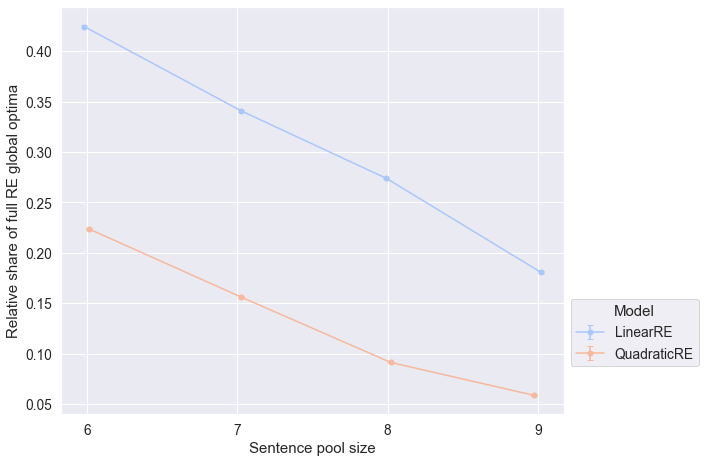

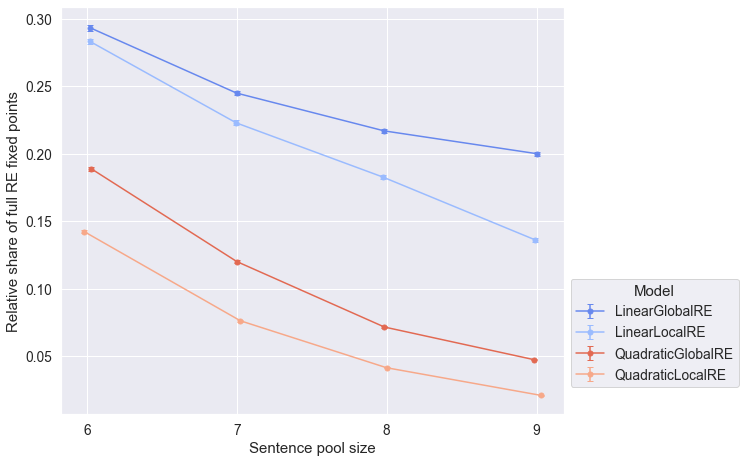

In [28]:
for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    alt_labels = None
    perspective = "pp" if analyse_branches else "rp"
    
    if endpoint_type=="go":
        
        endpoint = "global optima"
        df = df[df["model_name"].isin(go_models)]
        alt_labels = {'QuadraticGlobalRE':'QuadraticRE', 'LinearGlobalRE':'LinearRE'}
        
    else:
        
        endpoint = "fixed points"
        
    
    result_df = rel_share_of_property(df, 
                           "{}_full_re_state".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols= ["model_name", "n_sentence_pool"],
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
     
    
    file_name = None
    if not on_colab:
        file_name = f"rel_full_re_{endpoint_type}_by_sp_{perspective}"
    
    xticks = np.sort(df["n_sentence_pool"].unique())

    
    plot_multiple_error_bars(result_df.reset_index(), 
                             var_y = f"rel_{endpoint_type}_full_re_state", 
                             ylabel = f"Relative share of full RE {endpoint}",
                             xlabel = "Sentence pool size",
                             xticks = xticks,
                             alt_labels = alt_labels,
                             var_std = f"std_{endpoint_type}_full_re_state",
                             file_name = file_name,
                             output_dir = figures_output_dir)
    
    plt.show()

#### Results grouped by weight configuration

C:\Users\afrei\AppData\Local\Temp/ipykernel_5324/3804072773.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



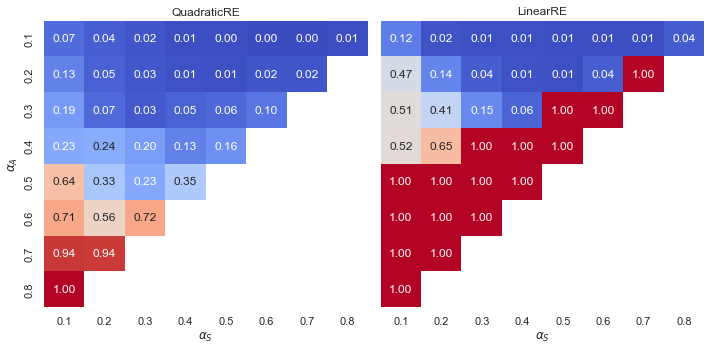

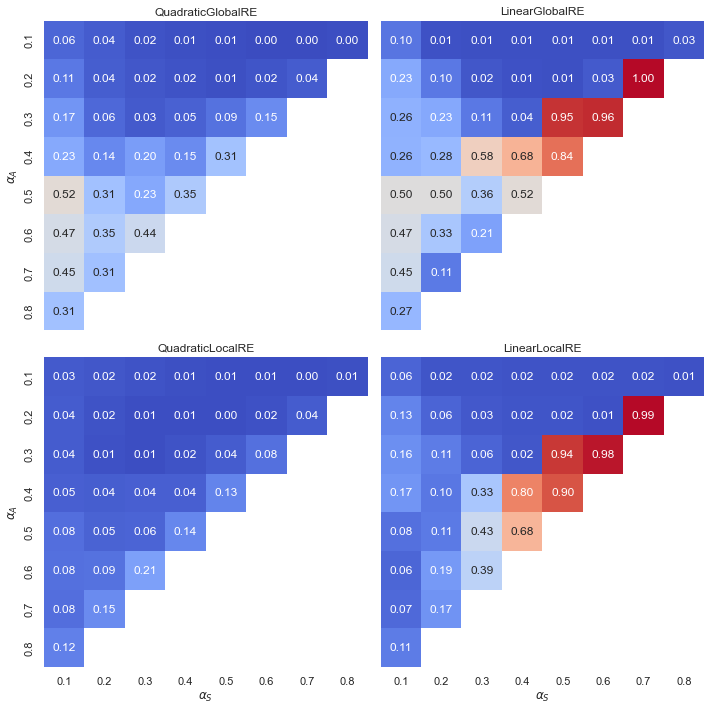

In [29]:
for data, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        rdata = data[data["model_name"].isin(go_models)]
        
        # rename model variants
        rdata["model_name"] = rdata.apply(lambda row: "QuadraticRE" if row["model_name"]=="QuadraticGlobalRE" 
                                      else "LinearRE",
                                          axis=1) 
        
    else:
        rdata=data

    endpoint = "global opima" if endpoint_type == "go" else "fixed points"
    
    if (analyse_branches) & (endpoint_type=="fp"):
        endpoint += " (all branches)"
    
    heat_maps_by_weights(re_data = rdata, 
                     values = "{}_full_re_state".format(endpoint_type), 
                     #title = 'Relative share of full RE states among {}'.format(endpoint),
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.3f}',
                     vmin=0, vmax=1,
                     bootstrap=bootstrap,
                     n_resamples=n_resamples)
    
    
    branches = "pp" if analyse_branches else "rp"
        
    if not on_colab:
        plt.savefig(path.join(figures_output_dir, 'hm_rel_{}_full_re_{}.png'.format(endpoint_type, branches)), bbox_inches='tight')
        plt.savefig(path.join(figures_output_dir, 'hm_rel_{}_full_re_{}.pdf'.format(endpoint_type, branches)), bbox_inches='tight')
        
    plt.show()